## Mosaic the image

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from colour_demosaicing import masks_CFA_Bayer

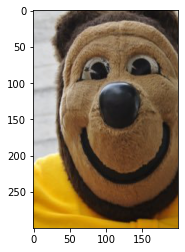

In [3]:
image = imread('image/oski.png', 'png')
shape = (300, 200)
start = (50, 50)
image = image[start[0]:start[0]+shape[0], start[1]:start[1]+shape[1], :] # crop the image
plt.imshow(image)

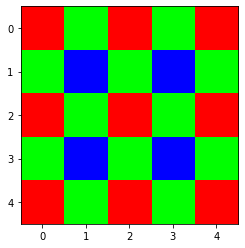

In [4]:
# construct the bayer pattern filter
bayer_filter = np.stack(masks_CFA_Bayer(shape), axis=-1).astype(float)
plt.imshow(bayer_filter[50:55, 50:55, :])

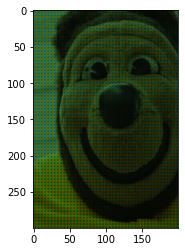

In [5]:
# mosaic the image by applying the Bayer CFA
mosaic_image = image * bayer_filter
plt.imshow(mosaic_image)

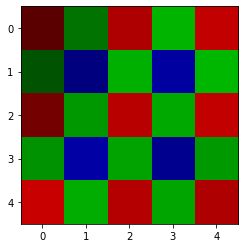

In [6]:
# compared the filtered image and the filter at the same area
plt.imshow(mosaic_image[50:55, 50:55])

**Observation:** There are positions of the mosaic image with zero values in all the channels. 

In [7]:
mosaic_image[299:, 155:160]

array([[[ 0.        ,  0.        ,  0.00392157],
        [ 0.        ,  0.51372552,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.52156866,  0.        ],
        [ 0.        ,  0.        ,  0.01176471]]])

All of the entries in row 3 are zero.

In [8]:
image[299:, 155:160]

array([[[ 0.8039216 ,  0.5176471 ,  0.00392157],
        [ 0.8039216 ,  0.5137255 ,  0.        ],
        [ 0.8117647 ,  0.50980395,  0.        ],
        [ 0.79607844,  0.52156866,  0.00392157],
        [ 0.7921569 ,  0.52156866,  0.01176471]]], dtype=float32)

In [9]:
bayer_filter[299:, 155:160]

array([[[ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.]]])

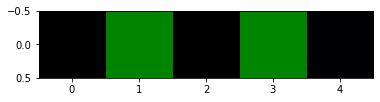

In [10]:
plt.imshow(mosaic_image[299:, 155:160])

## Building the algorithm

### Original

Below is the alternating maximization oracle which is bacially the original alternating minimization orcale with a few changes.

In [27]:
# Alternating maximization oracle
def altmax(r, lpar, p, tol, cmax, gap, c, the_q, Un):
    the = the_q.copy()
    cum_r = np.insert(np.cumsum(r), 0, 0)
    un = Un.shape[0]

    last_cmax = cmax - 1e6
    cnt = 0
    while (True):
        cnt += 1
        for ind in range(p):
            pro = lpar*c.copy()
            for k in range(p):
                if (ind != k):
                    pro = np.multiply(pro, the[cum_r[k] + Un[:,k]]) 

            fpro = np.zeros(r[ind])
            for k in range(un):
                fpro[Un[k,ind]] += pro[k]
            the[cum_r[ind]:cum_r[ind+1]] = (fpro >= 0).astype(int)
            curr_cmax = np.sum(fpro[fpro >= 0])

        if (curr_cmax < last_cmax + tol):
            break
        else:
            last_cmax = curr_cmax

    psi = np.ones(un)
    for k in range(p):
        psi = np.multiply(psi, the[cum_r[k] + Un[:,k]])

    return(psi, the, curr_cmax)

In [28]:
r = image.shape
p = len(r)
lpar = 1
tol = 1e-4
cmax = -float('inf')

# with projection on U
Un = np.argwhere(bayer_filter == 1)
# # without projection on U
# Un = np.arange(np.prod(r)) 
# Un = np.unravel_index(Un, r)
# Un = np.vstack(Un).T

un = len(Un)

mu = []
N_t = 0

# with projection on U
psi_t = np.zeros(un)
# # without projection on U
# psi_t = np.zeros(np.prod(image.shape))

the = np.round(np.random.uniform(0,1,np.sum(r)))

# with projection on U
p_t = mosaic_image.flatten()[bayer_filter.flatten() == 1]
# # without projection on U
# p_t = mosaic_image.flatten()

q_ts = []

cnt = 0

In [29]:
# while (N_t <= lpar):
#     cnt += 1
#     q_t, the_t, _ = altmax(r, lpar, p, tol, cmax, None, p_t, the, Un)
#     mu_t = np.min((p_t / q_t)[q_t > 0])
#     mu.append(mu_t)
#     p_t = p_t - mu_t * q_t
#     psi_t = psi_t + mu_t * q_t
#     N_t = N_t + mu_t
#     print(q_t.sum())
#     if cnt == 20:
#         break

**Observation**: All the entries of the alternating maximization solution, $q_t$, are always 1. I think it is because $c$ which is $p_t$ here is nonnegative, so trivially the solution always has all the entries being 1.

**Observation**: The $\mu$'s are all zeros. I think this is because some entries of $p_t$ are zero, as we saw before, $mu$ has to be zero to satisfy the nonnegativity constraint.

### Solution
Set the entries of $q_t$ where the corresponding $p_t$ is zero to zero. The following is the updated algorithm

In [30]:
r = image.shape
p = len(r)
lpar = 1
tol = 1e-4
cmax = -float('inf')

# with projection on U
Un = np.argwhere(bayer_filter == 1)
# # without projection on U
# Un = np.arange(np.prod(r)) 
# Un = np.unravel_index(Un, r)
# Un = np.vstack(Un).T

un = len(Un)

mu = []
N_t = 0

# with projection on U
psi_t = np.zeros(un)
# # without projection on U
# psi_t = np.zeros(np.prod(image.shape))

# with projection on U
p_t = mosaic_image.flatten()[bayer_filter.flatten() == 1]
# # without projection on U
# p_t = mosaic_image.flatten()

q_ts = []

cnt = 0

In [31]:
while (N_t <= lpar):
    cnt += 1
    the = np.round(np.random.uniform(0,1,np.sum(r)))
    q_t, the_t, _ = altmax(r, lpar, p, tol, cmax, None, p_t, the, Un)
    q_t[p_t == 0] = 0 # CHANGE
    q_ts.append(q_t)
    # the_t[TODO] = 0 
    mu_t = np.min((p_t / q_t)[q_t > 0])
    mu.append(mu_t)
    p_t = p_t - mu_t * q_t
    psi_t = psi_t + mu_t * q_t
    N_t = N_t + mu_t

    if p_t.sum() == 0: # the tensor has been fully decomposed
        break

C:\Users\Wenhao\AppData\Local\Temp\ipykernel_21524\2440312554.py:8: RuntimeWarning: invalid value encountered in true_divide
  mu_t = np.min((p_t / q_t)[q_t > 0])


$\psi_t$ is exactly the same as the demosic image!

In [32]:
np.all((mosaic_image.flatten()[bayer_filter.flatten() == 1] == psi_t))

True

## Modularizing the algorithm

Below I updated the alternating maximization oracle by making it solved only over $\mathcal{C}_1$. Then, we multiply the solution with the `lpar`, $\lambda$.

In [1]:
# alternating maximization oracle
def altmax(r, p, gamma, tol, cmax, c, the_q, Un):
    the = the_q.copy()
    cum_r = np.insert(np.cumsum(r), 0, 0)
    un = Un.shape[0]

    last_cmax = cmax - 1e6
    cnt = 0
    while (True):
        cnt += 1
        for ind in range(p):
            pro = c.copy()
            for k in range(p):
                if (ind != k):
                    #pro = np.multiply(pro, the[cum_r[k] + Un[:,k]])
                    mask = (the[cum_r[k] + Un[:,k]] == 0)
                    pro[mask] = 0 

            fpro = np.zeros(r[ind])
            # Original
            # for k in range(un):
            #     fpro[Un[k,ind]] += pro[k]

            # Speed up 1
            for k in np.argwhere(pro != 0):
                fpro[Un[k,ind]] += pro[k]
            
            # Speed up 2
            

            mask = (fpro >= np.sort(fpro)[r[ind] - gamma[ind]])
            #if ind < 2:
            #    mask = (fpro >= np.sort(fpro)[r[ind] - mu[ind]])
            #else:
            #    mask = np.full(r[ind], True)
            the[cum_r[ind]:cum_r[ind+1]] = (mask).astype(int)
            curr_cmax = np.sum(fpro[mask])

        if (curr_cmax < last_cmax + tol):
            break
        else:
            last_cmax = curr_cmax

    psi = np.ones(un)
    for k in range(p):
        psi = np.multiply(psi, the[cum_r[k] + Un[:,k]])

    return(psi, the, curr_cmax)

    
def heuristic(p_0, filter, gamma, proj=False, lpar=1, tol=1e-4):
    """
    Deflate/decompose the tensor p_0 of the mosaic image
    ---
    Arguments:
    p_0 (np.array): the mosaic image
    filter (np.array): the filter used to mosaic the image
    gamma (list[scalar]): the l1 norm upper constraint on every theta
    proj (bool): working in proj_U(C_lpar) if True
    lpar (scalar): the lambda parameter
    tol (scalar): the tolarance used in the alternating maximization

    Returns:
    psi_t (np.array): the flatten version
    Psi_t (np.array): the original version
    mu (list[scalar]): a list of mu_t
    q (list[np.array]): a list of q_t
    """

    # initializing parameters
    r = p_0.shape
    p = len(r)
    cmax = -float('inf')
    if proj:
        Un = np.argwhere(filter == 1)      
        p_t = p_0.flatten()[bayer_filter.flatten() == 1]
    else:
        Un = np.arange(np.prod(r)) 
        Un = np.unravel_index(Un, r)
        Un = np.vstack(Un).T
        p_t = mosaic_image.flatten()
    un = len(Un)
    N_t = 0
    psi_t = np.zeros(un)
    mu = []
    q = []

    # the deflation algorithm
    while (N_t <= lpar):
        print(N_t)
        the = np.round(np.random.uniform(0,1,np.sum(r)))
        q_t, _, _ = altmax(r, p, gamma, 0.01, cmax, p_t, the, Un)
        q.append(q_t)
        mu_t = np.min((p_t / q_t)[(p_t > 0) & (q_t > 0)])
        mu.append(mu_t)
        p_t = p_t - mu_t * q_t
        psi_t = psi_t + mu_t * q_t
        N_t = N_t + mu_t

        if p_t.sum() == 0: # the tensor has been fully decomposed
            break
    
    # recover the original shape
    if proj:
        Psi_t = np.zeros(image.shape)
        np.put(Psi_t, np.ravel_multi_index(Un.T.tolist(), image.shape), psi_t)
    else:
        Psi_t = psi_t.reshape(r)

    return psi_t, Psi_t, mu, q
        

## Experiment

$\lambda = 1$

0
0.823529422283


C:\Users\Wenhao\AppData\Local\Temp\ipykernel_25564\953142049.py:91: RuntimeWarning: divide by zero encountered in true_divide
  mu_t = np.min((p_t / q_t)[(p_t > 0) & (q_t > 0)])
C:\Users\Wenhao\AppData\Local\Temp\ipykernel_25564\953142049.py:91: RuntimeWarning: invalid value encountered in true_divide
  mu_t = np.min((p_t / q_t)[(p_t > 0) & (q_t > 0)])


1.7529411912
2.5607843399
3.49019610882
4.40392160416
5.31764709949
5.94509810209
6.78823536634
7.36470597982
8.21960794926
9.1333334446
9.99607855082
10.9529412985
11.8078432679
12.658823669
13.5843138695
14.4823530912
15.3490197659
15.9764707685
16.8196080327
17.6705884337
18.4431374669
19.2666668892
20.1333335638
20.9725492597
21.5490198731
22.3607845902
23.2156865597
24.039215982
24.7019611001
25.2352944613
25.8627454638
26.4235298038
27.3137258887
28.2078435421
29.0666670799
29.9254906178
30.5411769152
31.3725494742
32.1176475286
32.7215691209
33.254902482
34.0196083784
34.8705887794
35.6823534966
36.5294123292
37.3803927302
38.2196084261
39.058824122
39.8980398178
40.7333339453
41.5803927779
42.1098045707
42.9490202665
43.7803928256
44.6039222479
45.2549026608
46.0666673779
46.6235301495
47.3921576142
48.141177237
48.9607850909
49.7764713764
50.5490204096
51.3686282635
52.2000008225
53.03529495
53.8901969194
54.647059679
55.317647934
56.1568636298
56.9843146205
57.8117656112
58.6

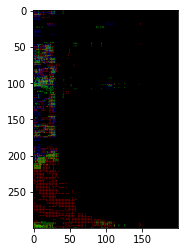

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from colour_demosaicing import masks_CFA_Bayer

shape = (300, 200)
start = (50, 50)
image = imread('image/oski.png', 'png')   
image = image[start[0]:start[0]+shape[0], start[1]:start[1]+shape[1], :]

bayer_filter = np.stack(masks_CFA_Bayer(shape), axis=-1).astype(float)
mosaic_image = image * bayer_filter

psi_t_unproj, Psi_t_unproj, mu_unproj, q_unproj = heuristic(mosaic_image, bayer_filter, [5, 5, 1], proj=False, lpar=500)

fig, ax = plt.subplots()
ax.imshow(Psi_t_unproj)
fig.savefig('recover.png')

In [10]:
q_unproj

[array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0